# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification. 

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [1]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [3]:
# Define the data augmentation transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

100%|██████████| 170498071/170498071 [00:05<00:00, 29565621.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 ship   car   car   cat


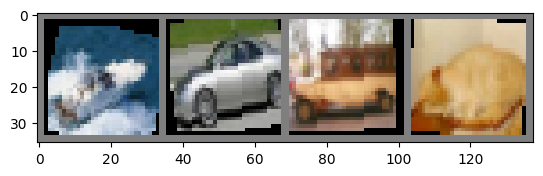

In [4]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [5]:
import torch
import torch.nn as nn
from torchsummary import summary

# VGG Model

#cfg = {'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']}
cfg = {'VGG16' : [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M']}

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = self.make_layers(cfg['VGG16'])
        self.classifier = nn.Linear(512, 10)

    def make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
        return nn.Sequential(*layers)


    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


net = VGG16().cuda()

# Create a random input tensor on the GPU
input_shape = (3, 32, 32)
input_tensor = torch.randn(1, *input_shape).cuda()

# Print the summary of your network
summary(net, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [6]:
# Loss function and optimizer
loss_fun = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00001)
#optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001, weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# **Train the network**

Train your own network using the above loss function and optimizer.

[Epoch - 1, Iteration -    32] Loss: 2.250
[Epoch - 1, Iteration -    64] Loss: 1.056
[Epoch - 1, Iteration -    96] Loss: 0.706
[Epoch - 1, Iteration -   128] Loss: 0.530
[Epoch - 1, Iteration -   160] Loss: 0.413
[Epoch - 1, Iteration -   192] Loss: 0.329
[Epoch - 1, Iteration -   224] Loss: 0.281
[Epoch - 1, Iteration -   256] Loss: 0.250
[Epoch - 1, Iteration -   288] Loss: 0.217
[Epoch - 1, Iteration -   320] Loss: 0.191
[Epoch - 1, Iteration -   352] Loss: 0.181
[Epoch - 1, Iteration -   384] Loss: 0.162
[Epoch - 1, Iteration -   416] Loss: 0.150
[Epoch - 1, Iteration -   448] Loss: 0.134
[Epoch - 1, Iteration -   480] Loss: 0.128
[Epoch - 1, Iteration -   512] Loss: 0.120
[Epoch - 1, Iteration -   544] Loss: 0.112
[Epoch - 1, Iteration -   576] Loss: 0.105
[Epoch - 1, Iteration -   608] Loss: 0.096
[Epoch - 1, Iteration -   640] Loss: 0.094
[Epoch - 1, Iteration -   672] Loss: 0.084
[Epoch - 1, Iteration -   704] Loss: 0.079
[Epoch - 1, Iteration -   736] Loss: 0.077
[Epoch - 1,

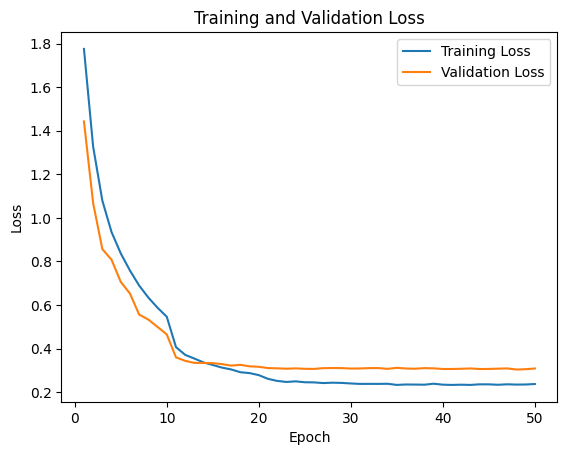

Finished Training


In [7]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming you have defined and loaded your trainset and valset

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# Rest of your code for model definition, optimizer, and loss function

net = net.to(device)  # Move the model to the GPU

epochs = 50  # number of epochs
train_loss = []  # to store training loss
val_loss = []  # to store validation loss

for epoch in range(epochs):
    loss_tmp = 0.0
    epoch_loss = 0.0
    running_loss = 0.0
  
    for i, data in enumerate(trainloader, start=0):
        # Load the data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = net(inputs)

        # Calculate the loss between the output of the network and label
        loss = loss_fun(outputs, labels)

        # Optimize the network 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tmp += loss.item()
        epoch_loss += loss.item()

        if i % 32 == 31:    # Print loss every 32 mini-batches
            print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, loss_tmp / (i+1)))
            loss_tmp = 0.0

    # Update the learning rate according to the learning rate scheduler
    scheduler.step()

    # Print the epoch loss
    print('[Epoch - %d] Loss: %.3f' %(epoch + 1, epoch_loss / (i+1)))
    train_loss.append(epoch_loss / (i+1))

    # Compute validation loss
    net.eval()  # Set the model to evaluation mode
    val_loss_tmp = 0.0
    
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            val_loss_batch = loss_fun(outputs, labels)
            val_loss_tmp += val_loss_batch.item()

    avg_val_loss = val_loss_tmp / len(valloader)
    val_loss.append(avg_val_loss)
    
    net.train()  # Set the model back to training mode

# Plotting the graph
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

print('Finished Training')

# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network. 

The closer the accuray is to 100%, the better the network classifies the input image.

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


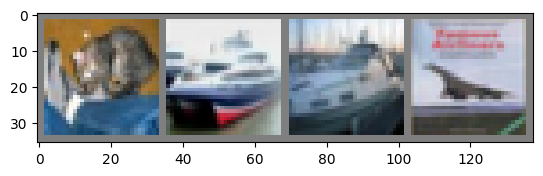

In [8]:
# Test the trained model with sample
net.eval()
dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [11]:
# Test the trained model with overall test dataset

correct = 0
total = 0
with torch.no_grad():
  net.eval() #do not use the dropout at test time
  for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)
   
    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10,000 test images: 89.65 %
